In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))])

train_data = datasets.CIFAR10('data',
                              train=True,
                              transform=transform,
                              download=True)

test_data = datasets.CIFAR10('data',
                             train=False,
                             transform=transform,
                             download=True)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(num_train * valid_size))
train_idx, valid_idx = indices[split:], indices[:split]

print(len(train_idx), len(valid_idx))

40000 10000


In [4]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

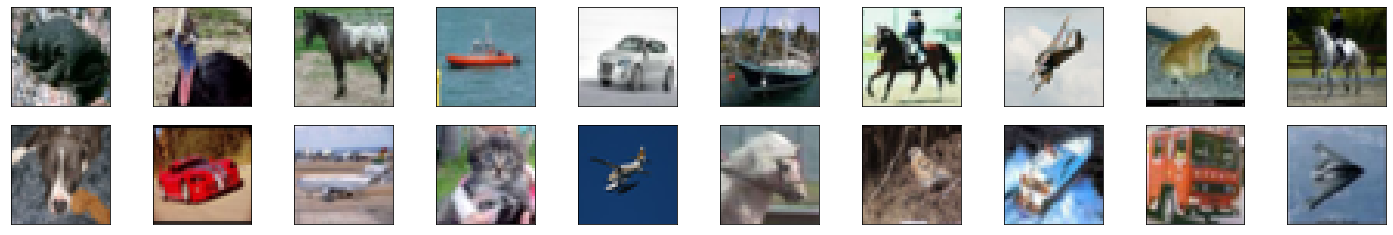

In [5]:
#Function to un-normalize and display images
def imshow(img):
    
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)))   #Convert from Tensor

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    img = images[idx]
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(img)

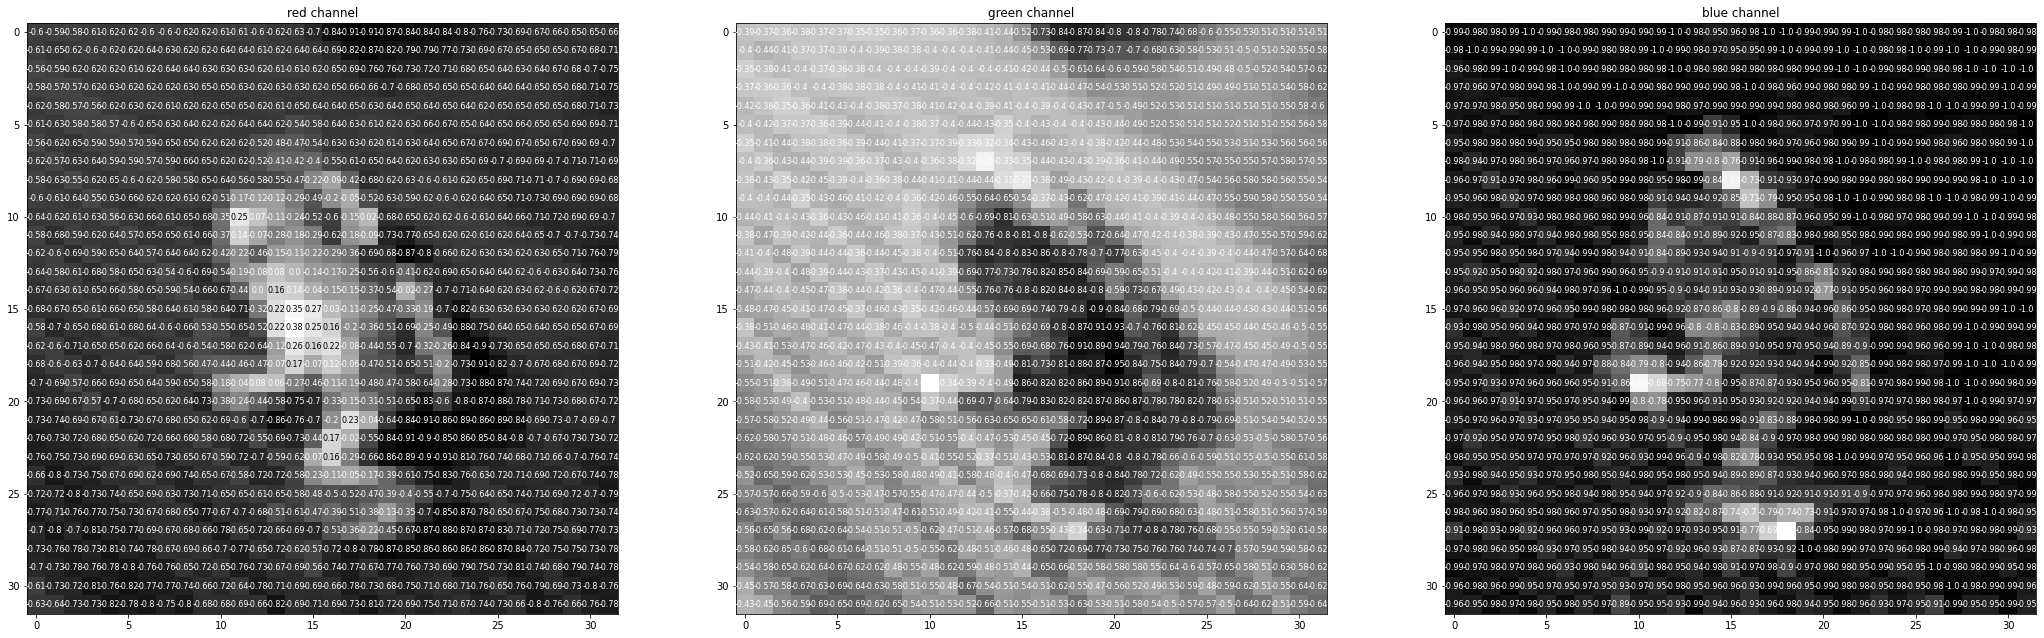

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
            
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
            
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2,2)
            
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64*4*4)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()

In [9]:
epochs=10
valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    
    for image, label in train_loader:
        
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * image.size(0)
        
    model.eval()
    
    for image, label in valid_loader:
        
        output = model(image)
        loss = criterion(output, label)
        
        valid_loss += loss.item() * image.size(0)
        
    trainloss = train_loss/len(train_loader.dataset)
    validloss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(epoch+1, trainloss, validloss))
    if validloss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). \t Saving model...'.format(valid_loss_min,validloss))
        torch.save(model.state_dict(), 'model_CIFAR.pt')
    
    valid_loss_min = validloss

Epoch: 1 	 Training Loss: 1.681276 	 Validation Loss: 0.353151
Validation loss decreased (inf --> 0.353151). 	 Saving model...
Epoch: 2 	 Training Loss: 1.320613 	 Validation Loss: 0.299247
Validation loss decreased (0.353151 --> 0.299247). 	 Saving model...
Epoch: 3 	 Training Loss: 1.178412 	 Validation Loss: 0.270921
Validation loss decreased (0.299247 --> 0.270921). 	 Saving model...
Epoch: 4 	 Training Loss: 1.082105 	 Validation Loss: 0.255229
Validation loss decreased (0.270921 --> 0.255229). 	 Saving model...
Epoch: 5 	 Training Loss: 1.006849 	 Validation Loss: 0.229809
Validation loss decreased (0.255229 --> 0.229809). 	 Saving model...
Epoch: 6 	 Training Loss: 0.942322 	 Validation Loss: 0.214358
Validation loss decreased (0.229809 --> 0.214358). 	 Saving model...
Epoch: 7 	 Training Loss: 0.883766 	 Validation Loss: 0.206943
Validation loss decreased (0.214358 --> 0.206943). 	 Saving model...
Epoch: 8 	 Training Loss: 0.833017 	 Validation Loss: 0.192396
Validation loss de

In [8]:
model.load_state_dict(torch.load('model_CIFAR.pt'))

FileNotFoundError: ignored

In [12]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for image, target in test_loader:
    
    output = model(image)
    loss = criterion(output, target)
    test_loss += loss.item() * image.size(0)
    
    _, pred = torch.max(output, 1)
    #print(f'_, pred, {_}, {pred}')
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    #print(f'Correct tensor: {correct_tensor}, {correct_tensor.shape}')
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(batch_size):
        label = target.data[i]
        #print(f'Label: {label}')
        class_correct[label] += correct[i].item()
        class_total[label] += 1

    #print(f'class_correct: {class_correct}')
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.927437

Test Accuracy of airplane: 73% (731/1000)
Test Accuracy of automobile: 92% (929/1000)
Test Accuracy of  bird: 48% (483/1000)
Test Accuracy of   cat: 44% (444/1000)
Test Accuracy of  deer: 65% (657/1000)
Test Accuracy of   dog: 53% (533/1000)
Test Accuracy of  frog: 85% (857/1000)
Test Accuracy of horse: 74% (747/1000)
Test Accuracy of  ship: 69% (696/1000)
Test Accuracy of truck: 72% (724/1000)

Test Accuracy (Overall): 68% (6801/10000)


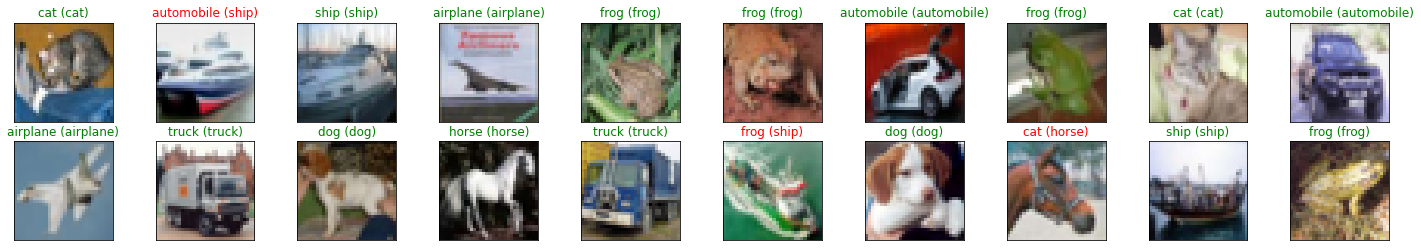

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 30/3, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))